In [29]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras.preprocessing import image
from os import listdir
from os.path import isfile, join
import re
import matplotlib.image as mpimg

In [30]:
num_classes = 95
img_rows, img_cols = 64, 64
batch_size = 32

train_data_dir = 'data/Training'
validation_data_dir = 'data/Test'

#data augmentaiton 
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.3, height_shift_range=0.3,
                                   horizontal_flip=True, fill_mode='nearest')
 
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size,
                                                    class_mode='categorical', shuffle=True)
 
test_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_rows, img_cols),
                                                              batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 48905 images belonging to 95 classes.
Found 16421 images belonging to 95 classes.


In [2]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape= (img_rows, img_cols, 3)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
__________

In [3]:
checkpoint = ModelCheckpoint("trained_model/fruits_1.h5", monitor="val_loss", mode="min", save_best_only = True, verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [earlystop, checkpoint, reduce_lr]

model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr = 0.001), metrics = ['accuracy'])

nb_train_samples = 48905 
nb_validation_samples = 16421 
epochs = 10

history = model.fit_generator(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = epochs, 
                              callbacks = callbacks, validation_data = test_generator, 
                              validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
1528/1528 [==============================] - 99s 65ms/step - loss: 1.6180 - acc: 0.5291 - val_loss: 0.2612 - val_acc: 0.9195

Epoch 00001: val_loss improved from inf to 0.26120, saving model to trained_model/fruits_1.h5
Epoch 2/10
1528/1528 [==============================] - 92s 60ms/step - loss: 0.4934 - acc: 0.8456 - val_loss: 0.1647 - val_acc: 0.9415

Epoch 00002: val_loss improved from 0.26120 to 0.16467, saving model to trained_model/fruits_1.h5
Epoch 3/10
1528/1528 [==============================] - 93s 61ms/step - loss: 0.3488 - acc: 0.8980 - val_loss: 0.3312 - val_acc: 0.9257

Epoch 00003: val_loss did not improve from 0.16467
Epoch 4/10
1528/1528 [==============================] - 92s 61ms/step - loss: 0.3238 - acc: 0.9109 - val_loss: 0.0808 - val_acc: 0.9774

Epoch 00004: val_loss improved from 0.16467 to 0.08082, saving model to trained_model/fruits_1.h5
Epoch 5/10
1528/1528 [==============================] - 92s 60ms/step - loss: 0.3363 - acc: 0.9166 - val_loss: 

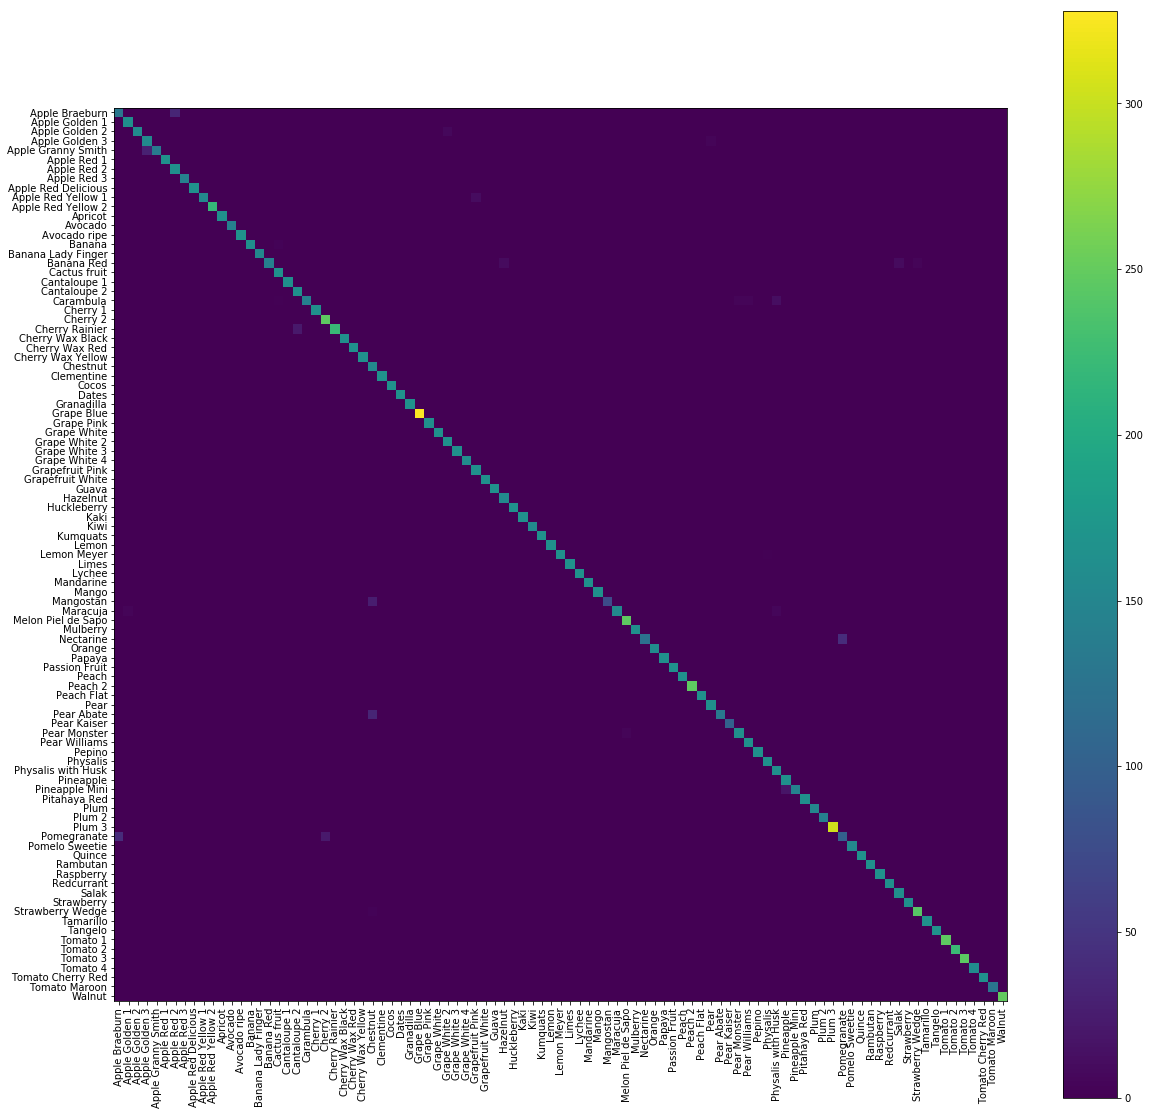

In [31]:
img_row, img_height, img_depth = 64,64,3
model = load_model('trained_model/fruits_1.h5')

class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 48905
nb_validation_samples = 16421

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [32]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 98  32   0 ...   0   0   0]
 [  0 131  32 ...   0   0   0]
 [  0   0 125 ...   0   0   0]
 ...
 [  0   0   0 ... 132  32   0]
 [  0   0   0 ...   0  95  32]
 [ 32   0   0 ...   0   0 217]]
Classification Report
                     precision    recall  f1-score   support

     Apple Braeburn       0.57      0.60      0.59       164
     Apple Golden 1       0.78      0.80      0.79       164
     Apple Golden 2       0.80      0.76      0.78       164
     Apple Golden 3       0.71      0.83      0.77       161
 Apple Granny Smith       0.83      0.68      0.74       164
        Apple Red 1       0.80      0.80      0.80       164
        Apple Red 2       0.67      0.80      0.73       164
        Apple Red 3       0.78      0.78      0.78       144
Apple Red Delicious       0.81      0.81      0.81       166
 Apple Red Yellow 1       0.84      0.78      0.81       164
 Apple Red Yellow 2       0.85      0.85      0.85       219
            Apricot       0.80      


( 1 )


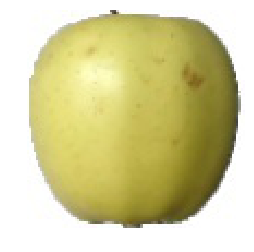

Predicted:  Apple Golden 2
True:  Apple Golden 2

( 2 )


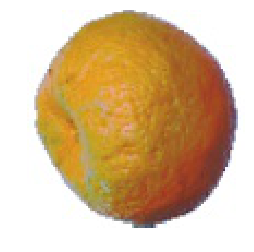

Predicted:  Mandarine
True:  Mandarine

( 3 )


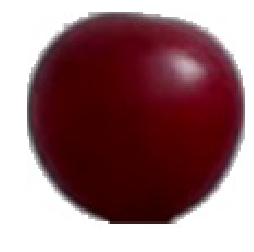

Predicted:  Cherry Wax Red
True:  Cherry Wax Red

( 4 )


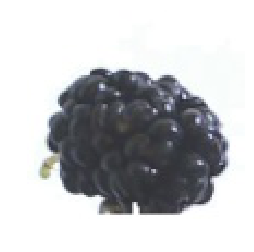

Predicted:  Mulberry
True:  Mulberry

( 5 )


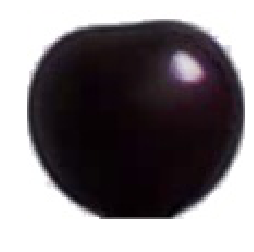

Predicted:  Cherry Wax Black
True:  Cherry Wax Black

( 6 )


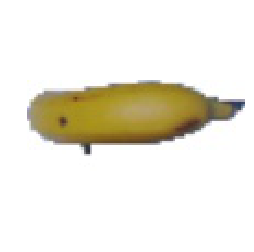

Predicted:  Banana
True:  Banana

( 7 )


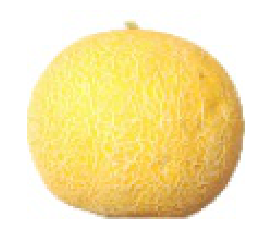

Predicted:  Cantaloupe 1
True:  Cantaloupe 1

( 8 )


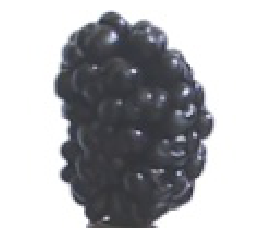

Predicted:  Mulberry
True:  Mulberry

( 9 )


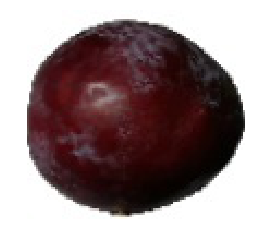

Predicted:  Plum
True:  Plum

( 10 )


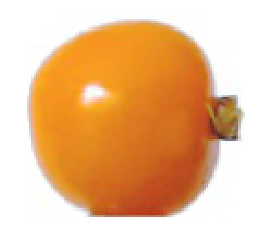

Predicted:  Physalis
True:  Physalis

( 11 )


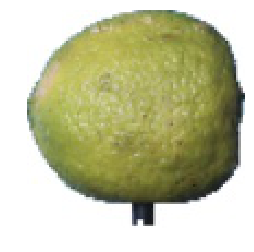

Predicted:  Limes
True:  Limes

( 12 )


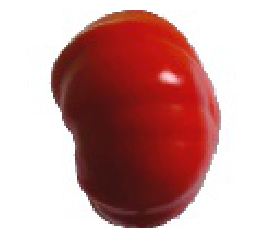

Predicted:  Tomato 3
True:  Tomato 3

( 13 )


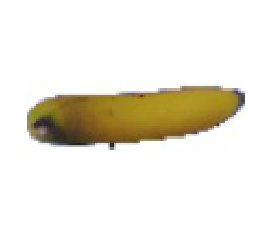

Predicted:  Banana
True:  Banana

( 14 )


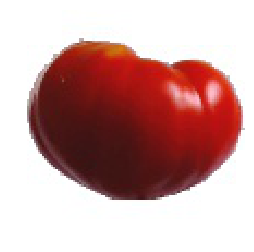

Predicted:  Tomato 3
True:  Tomato 3

( 15 )


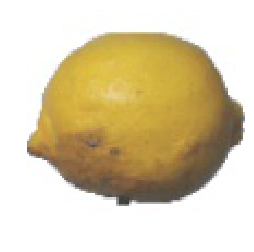

Predicted:  Lemon
True:  Lemon


In [39]:
def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 64, 64

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 15):
    path = 'data/Test/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    img=mpimg.imread((files[i]))
    print("\n(",i+1,")")
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Predicted: ", class_labels[predictions[i][0]])
    print("True: ", true_labels[i])